### Import libraries

In [1]:
import os
import sys
import time
import logging

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from hdf5storage import loadmat, savemat

import tensorflow as tf # This notebook was tested with TF-2.2.0

### Load sample data

Load provided sample data, which consists of a training set of 54 trials and a test set of multiple repetitions of 8 unique trials. Here, the repetitions of the test set have been already averaged into two groups of responses to odd repetitions and even repetitions. The stimuli are in form of auditory spectrograms of the presented audio and responses are preprocessed and z-scored highgamma envelopes of three sample ECoG electrodes.

$X_{tr}$ and $Y_{tr}$ are the stimulus and response data for the train set, respectively, while $X_{te}$ and $Y_{te}$ represent the test set. $X_{tr}$ and $X_{te}$ consist of multiple trials, each with shape $[time \times freq\_bins]$. $Y_{tr}$ and $Y_{te}$ have shapes $[time \times channels]$ and $[time \times channels \times repetitions]$ per trial, respectively.

In [2]:
data = loadmat('../sample_data.mat')

# train set
X_tr = data['X_tr'].flatten()
Y_tr = data['Y_tr'].flatten()

# test set
X_te = data['X_te'].flatten()
Y_te = data['Y_te'].flatten()

# separate even and odd repetitions of test set
Y_r0 = np.array([y[:,:,0::2].mean(-1) for y in Y_te])
Y_r1 = np.array([y[:,:,1::2].mean(-1) for y in Y_te])
Y_te = np.array([y.mean(-1) for y in Y_te])

# stimulus frequency channels
freq_bins = X_tr[0].shape[-1]

Display sample stimulus and response:

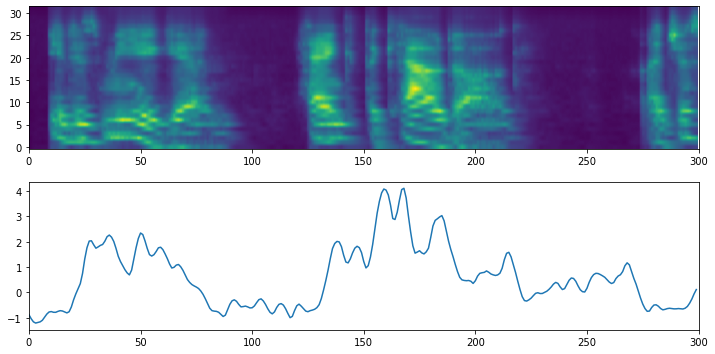

In [3]:
plt.figure(figsize=(12, 6))
plt.subplot(211), plt.imshow(X_tr[0][:300].T, origin="ll", aspect=2), plt.xlim([0, 300])
plt.subplot(212), plt.plot(Y_tr[0][:300,0]), plt.xlim([0, 300])
plt.show()

Split the train set into two train and validation subsets for training cross-validation. This data split can be done using jackknife, etc.

In [4]:
# set aside two trials for validation
trials_vl = np.zeros(len(X_tr), dtype=bool)
trials_vl[[1, 3]] = 1

X_vl = X_tr[trials_vl]
Y_vl = Y_tr[trials_vl]

X_tr = X_tr[~trials_vl]
Y_tr = Y_tr[~trials_vl]

### Select channel

Select target channel from list of electrodes. The new variables are 1-dimensional timecourses per trial.

In [5]:
channel = 1
print(f"Fitting models for channel {channel:d}...")

Y_tr = np.array([y[:, channel] for y in Y_tr])
Y_vl = np.array([y[:, channel] for y in Y_vl])
Y_te = np.array([y[:, channel] for y in Y_te])
Y_r0 = np.array([y[:, channel] for y in Y_r0])
Y_r1 = np.array([y[:, channel] for y in Y_r1])

Fitting models for channel 1...


### Prepare data for training

Concatenate all trials into a single numpy variable for ease of training. Trials are spaced by 500ms to avoid between-trial contamination by the network.

In [6]:
X_tr = np.concatenate([np.pad(x, ((25, 25), (0, 0)), constant_values=0) for x in X_tr])
Y_tr = np.concatenate([np.pad(x, ((25, 25),), constant_values=np.nan) for x in Y_tr])

X_vl = np.concatenate([np.pad(x, ((25, 25), (0, 0)), constant_values=0) for x in X_vl])
Y_vl = np.concatenate([np.pad(x, ((25, 25),), constant_values=np.nan) for x in Y_vl])

X_te = np.concatenate([np.pad(x, ((25, 25), (0, 0)), constant_values=0) for x in X_te])
Y_te = np.concatenate([np.pad(x, ((25, 25),), constant_values=np.nan) for x in Y_te])
Y_r0 = np.concatenate([np.pad(x, ((25, 25),), constant_values=np.nan) for x in Y_r0])
Y_r1 = np.concatenate([np.pad(x, ((25, 25),), constant_values=np.nan) for x in Y_r1])

print(X_tr.shape, X_vl.shape, X_te.shape)
print(Y_tr.shape, Y_vl.shape, Y_te.shape)

(166065, 32) (11109, 32) (4400, 32)
(166065,) (11109,) (4400,)


Split the data into continous chunks for batch training if needed.<br/>Network inputs must have shape $[batch \times time \times freq\_bins]$ and outputs must have shape $[batch \times time]$.

In [7]:
# use full data as single batch
X_tr = X_tr[np.newaxis]
Y_tr = Y_tr[np.newaxis]

X_vl = X_vl[np.newaxis]
Y_vl = Y_vl[np.newaxis]

X_te = X_te[np.newaxis]
Y_te = Y_te[np.newaxis]
Y_r0 = Y_r0[np.newaxis]
Y_r1 = Y_r1[np.newaxis]

print(X_tr.shape, X_vl.shape, X_te.shape)
print(Y_tr.shape, Y_vl.shape, Y_te.shape)

(1, 166065, 32) (1, 11109, 32) (1, 4400, 32)
(1, 166065) (1, 11109) (1, 4400)


### Define model

In [8]:
# drop nan elements for computing loss
def drop_nan(response, prediction):
    mask = tf.math.is_finite(response)
    return tf.boolean_mask(response, mask), tf.boolean_mask(prediction, mask)

# loss function
def loss_mse(response, prediction):
    """Squared error loss."""
    response, prediction = drop_nan(response, prediction)
    return tf.reduce_mean(tf.square(response - prediction))

# noise-corrected correlation
def fn_ncorr(prediction):
    mask = np.isfinite(Y_te)
    r0 = scipy.stats.pearsonr(Y_r0[mask], prediction[mask])[0]
    r1 = scipy.stats.pearsonr(Y_r1[mask], prediction[mask])[0]
    rr = scipy.stats.pearsonr(Y_r0[mask], Y_r1[mask])[0]
    return (r0 + r1)/2 / np.sqrt(rr)

In [16]:
l2 = tf.keras.regularizers.l2(0.0001)
layer_opts = dict(activation='relu', use_bias=False, kernel_regularizer=l2)

layers = (
    tf.keras.layers.InputLayer(input_shape=(None, freq_bins)),
    tf.keras.layers.Reshape((-1, freq_bins, 1)),
    
    tf.keras.layers.ZeroPadding2D(((2, 0), (1, 1))),
    tf.keras.layers.Conv2D(8, 3, **layer_opts),
    tf.keras.layers.ZeroPadding2D(((2, 0), (1, 1))),
    tf.keras.layers.Conv2D(8, 3, **layer_opts),
    tf.keras.layers.ZeroPadding2D(((2, 0), (1, 1))),
    tf.keras.layers.Conv2D(8, 3, **layer_opts),
    
    tf.keras.layers.Conv2D(4, 1, **layer_opts),
    tf.keras.layers.Conv2D(1, 1, **layer_opts),
    
    tf.keras.layers.ZeroPadding2D(((39, 0), (0, 0))),
    tf.keras.layers.Conv2D(1, (40, 32), use_bias=True, kernel_regularizer=l2),
    tf.keras.layers.Flatten()
)

blueprint = tf.keras.models.Sequential(layers)
blueprint.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, None, 32, 1)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, None, 34, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, 32, 8)       72        
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, None, 34, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, 32, 8)       576       
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, None, 34, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, 32, 8)      

### Fit model

In [17]:
# prepare directory for saving trained models
model_dir = f"models/"
os.makedirs(model_dir, exist_ok=True)

# path for saving model
model_path = os.path.join(model_dir, f"mdl-{channel:03d}.h5")

# initialize model from blueprint
model = tf.keras.models.clone_model(blueprint)
#optim = tf.keras.optimizers.RMSprop(1e-3, momentum=0.9)
optim = tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer=optim, loss=loss_mse)

# set callbacks
callbk_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50, mode='min', restore_best_weights=True, verbose=0)
callbk_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=0)
callbacks = [callbk_early_stop, callbk_checkpoint]

# fit model to data
history = model.fit(X_tr, Y_tr, validation_data=(X_vl, Y_vl),
                    epochs=500, verbose=1, callbacks=callbacks)

Epoch 1/500
1/1 [==============================] - 0s 331ms/step - loss: 1.0086 - val_loss: 0.9907
Epoch 2/500
1/1 [==============================] - 0s 30ms/step - loss: 0.9942 - val_loss: 0.9896
Epoch 3/500
1/1 [==============================] - 0s 22ms/step - loss: 0.9865 - val_loss: 0.9921
Epoch 4/500
1/1 [==============================] - 0s 29ms/step - loss: 0.9826 - val_loss: 0.9879
Epoch 5/500
1/1 [==============================] - 0s 30ms/step - loss: 0.9771 - val_loss: 0.9795
Epoch 6/500
1/1 [==============================] - 0s 29ms/step - loss: 0.9705 - val_loss: 0.9715
Epoch 7/500
1/1 [==============================] - 0s 28ms/step - loss: 0.9643 - val_loss: 0.9645
Epoch 8/500
1/1 [==============================] - 0s 30ms/step - loss: 0.9574 - val_loss: 0.9570
Epoch 9/500
1/1 [==============================] - 0s 34ms/step - loss: 0.9487 - val_loss: 0.9481
Epoch 10/500
1/1 [==============================] - 0s 29ms/step - loss: 0.9383 - val_loss: 0.9372
Epoch 11/500
1/1 [

Plot loss curves:

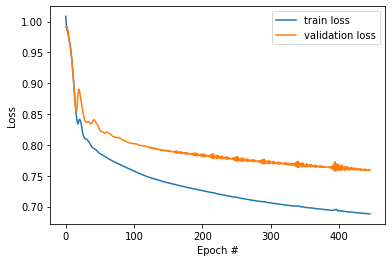

In [18]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.show()

### Evaluate performance on test set

In [19]:
# Load best model
model.load_weights(model_path)

# Predict and evaluate
pred = model(X_te)
corr = fn_ncorr(pred)

print(f"Noise-corrected correlation on test set: {corr:.3f}")

Noise-corrected correlation on test set: 0.847


### Calculate dynamic STRFs for trained model

Compute DSTRFs for trained model on test dataset. $dstrf$ has shape $[njacks \times time \times lag \times freq\_bins]$. Consider running on smaller chunks (i.e. < 550 samples) of data at a time and concatenating results to improve calculation speed. Here, 550 was chosen to separate the 8 trials.

In [20]:
# Prepad in time
def pad(x, n):
    return np.pad(x, ((n-len(x), 0), (0, 0))) if len(x)<n else x

# Load best model
model.load_weights(model_path)

# Chunk size to process input
chunk_size = 550

dstrf = []
for i in range(8):
    # Take chunk of input to process
    # x should have shape: [batch x time x freq_bins]
    x = tf.Variable(X_te[:,i*chunk_size:(i+1)*chunk_size])
    
    # Predict response with gradient tracking
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        z = model(x)
    
    # Calculate data Jacobian matrix dz/dx
    # dz_dx has shape: [batch x time x channel x lag x freq_bins]
    # We collapse the batch and channel dimensions, since they are both 1
    dz_dx = g.jacobian(z, x).numpy()[0,:,0,:,:]
    
    # Pick only the last 400 ms of the Jacobian for each time point, corresponding to the window
    # of our feed-forward model
    dz_dx = np.stack([pad(dz_dx[j, max(0, j-39):j+1, :], 40) for j in range(len(dz_dx))], 0)
    
    dstrf.append(dz_dx)

# Concatenate result from all chunks
# dstrf should have shape: [time x lag x freq_bins]
dstrf = np.concatenate(dstrf, axis=0)
print(dstrf.shape)

(4400, 40, 32)


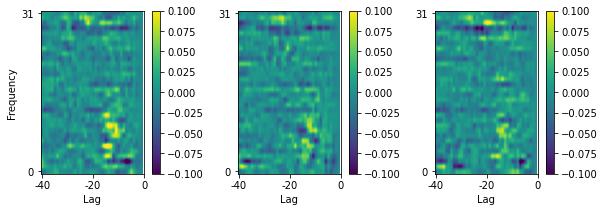

In [39]:
clim = 0.1

plt.figure(figsize=(10, 3))
plt.subplot(131), plt.imshow(dstrf[230].T, origin='ll', aspect=2, vmin=-clim, vmax=clim)
plt.colorbar(), plt.xlabel('Lag'), plt.ylabel('Frequency'), plt.xticks([0, 20, 40], [-40, -20, 0]), plt.yticks([0, 31])
plt.subplot(132), plt.imshow(dstrf[340].T, origin='ll', aspect=2, vmin=-clim, vmax=clim)
plt.colorbar(), plt.xlabel('Lag'), plt.xticks([0, 20, 40], [-40, -20, 0]),  plt.yticks([0, 31])
plt.subplot(133), plt.imshow(dstrf[830].T, origin='ll', aspect=2, vmin=-clim, vmax=clim)
plt.colorbar(), plt.xlabel('Lag'), plt.xticks([0, 20, 40], [-40, -20, 0]),  plt.yticks([0, 31])
plt.show()

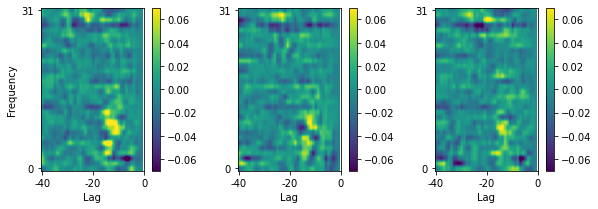

In [38]:
def smooth(x):
    return scipy.ndimage.gaussian_filter(x, 0.5)

clim = 0.07

plt.figure(figsize=(10, 3))
plt.subplot(131), plt.imshow(smooth(dstrf[230].T), origin='ll', aspect=2, vmin=-clim, vmax=clim)
plt.colorbar(), plt.xlabel('Lag'), plt.ylabel('Frequency'), plt.xticks([0, 20, 40], [-40, -20, 0]), plt.yticks([0, 31])
plt.subplot(132), plt.imshow(smooth(dstrf[340].T), origin='ll', aspect=2, vmin=-clim, vmax=clim)
plt.colorbar(), plt.xlabel('Lag'), plt.xticks([0, 20, 40], [-40, -20, 0]),  plt.yticks([0, 31])
plt.subplot(133), plt.imshow(smooth(dstrf[830].T), origin='ll', aspect=2, vmin=-clim, vmax=clim)
plt.colorbar(), plt.xlabel('Lag'), plt.xticks([0, 20, 40], [-40, -20, 0]),  plt.yticks([0, 31])
plt.show()

To obtain less noisy DSTRFs, we can train multiple networks using data jackknifing, random initializations, etc., and average across the instances.

### TODO

1. Add jackknife procedure to model training.
    - Data will be split into $N$ segments.
    - Each time one segment will be left out and model trained on remaining $N-1$ segments.
    - Model will be evaluated on independent test set and DSTRFs calculated.
    - DSTRFs would have shape: $[N \times time \times lag \times freq\_bins]$
    - Significance bounds on DSTRFs will be computed:

In [15]:
# Create dummy jackknife dimension for now
dstrf_jk = np.expand_dims(dstrf, 0)

# Compute 5% and 95% percentiles and determine significance bound
dstrf_05, dstrf_95 = np.quantile(dstrf_jk, [0.05, 0.95], 0)
dstrf_sig = (dstrf_05 > 0) | (dstrf_95 < 0)

# Compute DSTRF average from jackknifed data
dstrf_mean = dstrf_jk.mean(0)

2. Port nonlinearity calculation code from Matlab to Python.